# SIMPLE IMAGE PROCESSING NEURAL NETWORK

We are going to try to make very simple neural network that is able to detect edges in an image


### Part 1: Building the network

The network will consist on $n$ neurons recieving the amount of light of a certain pixel and $m$ neurons detecting the edge.
We will first build a model with $n = 5, m = 3$.
The model we will use to simulate the neurons will be the **simple model**, so the first thing to do is add all the parameters and functions necessary.
We also will need a weigh matrix $W_{(n+m)\times(n+m)}$ to represent the outside inputs comming to the $n$ first neurons and a matrix $M_{(n+m)\times(n+m)}$ representing the connection between the first neurons and the $m$ second ones.

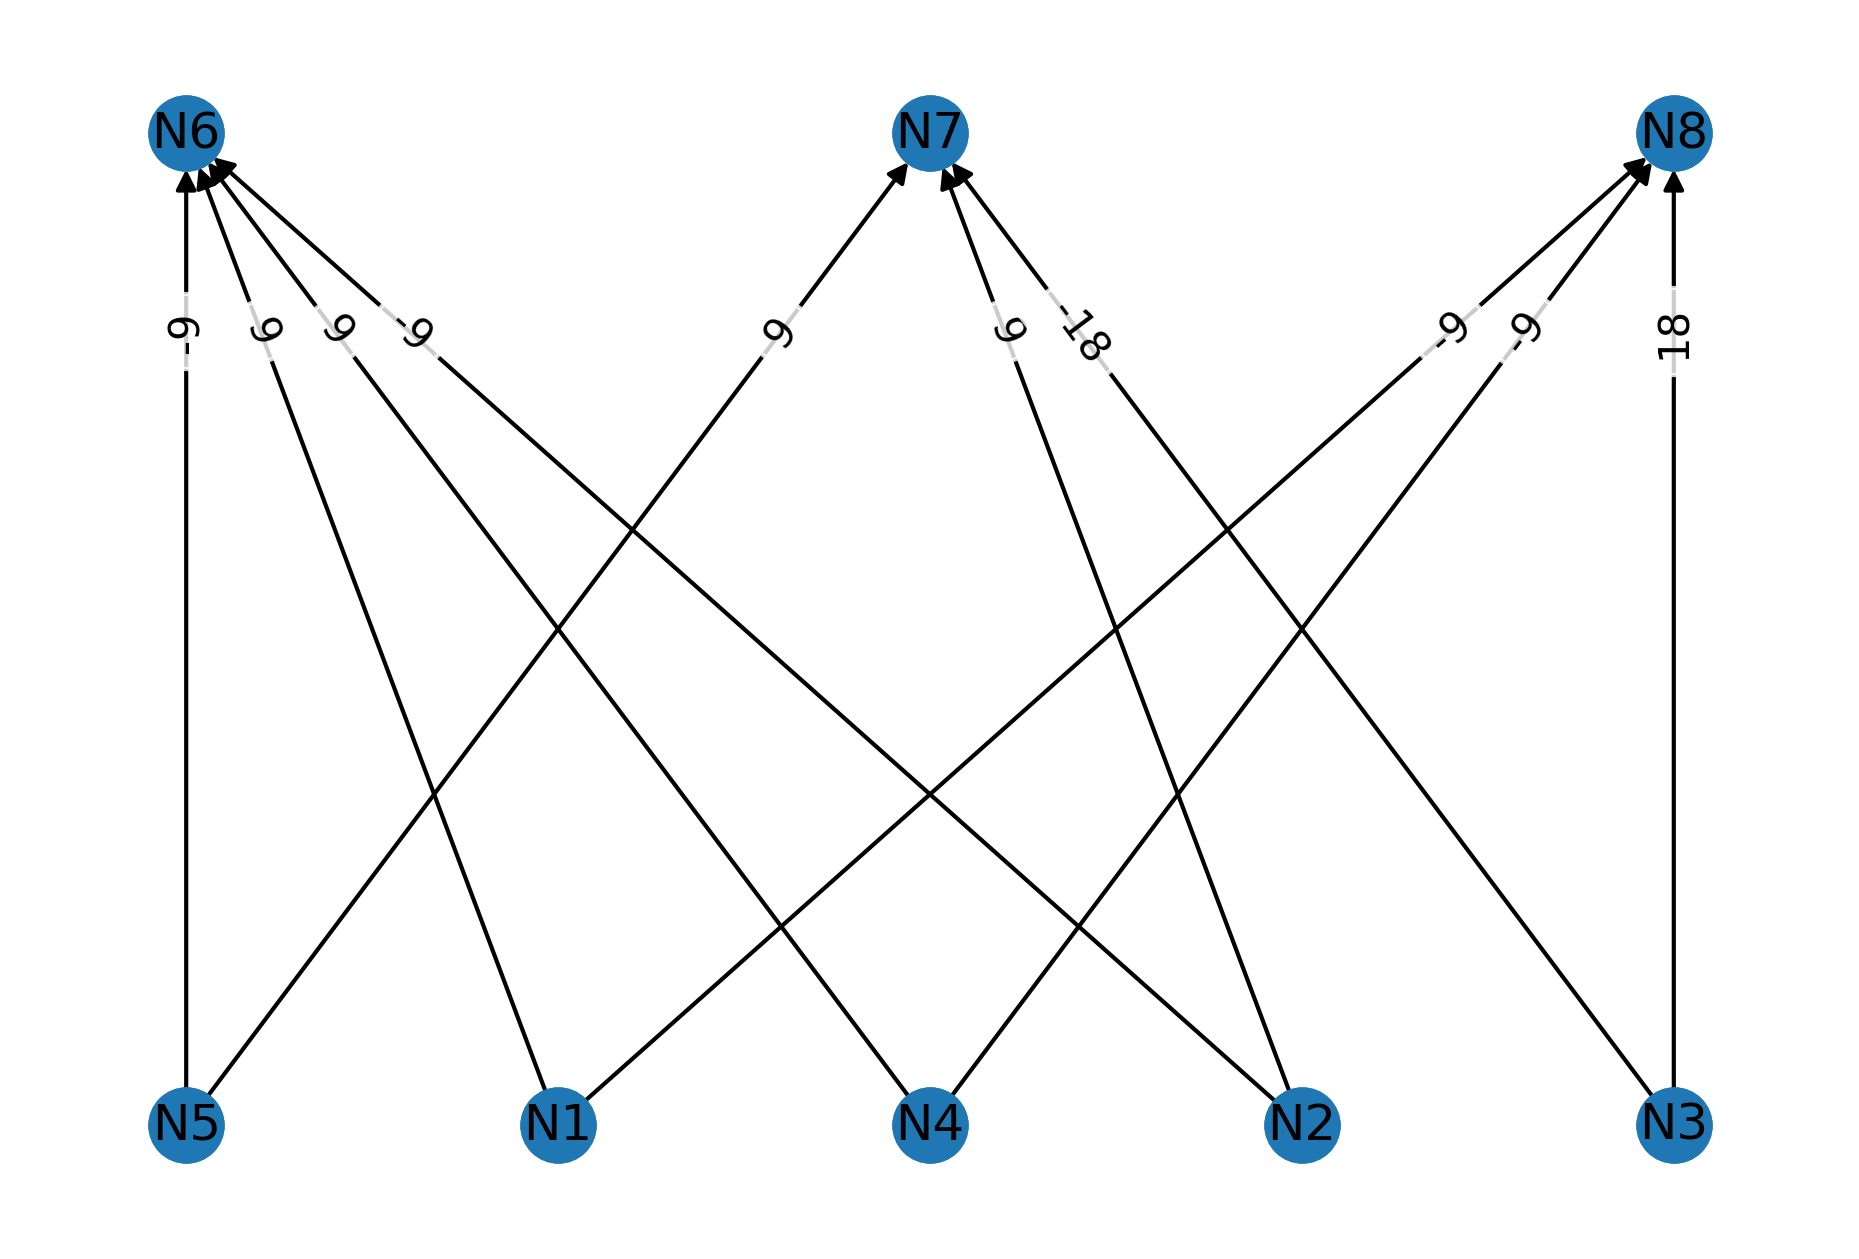

In [2]:
%matplotlib inline
from re import U
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import scipy.integrate
import scipy
import networkx as nx 
from progress.bar import IncrementalBar
from PIL import Image
import bisect
import cv2
plt.rcParams['figure.dpi']= 300


# Parameter definitions
V_rest = -70 # mV
V_reset= -80 # mV
R_m    =  10 # Mohm
tau_m  =  10 # ms
V_th   = -54 # mV
I      =  1.7 # nA
T      = 300
gmax   = 50 #nS
tau_s  = 5.4
EsE    = 0 #mV
EsI    = -80 #mV
tau_p  = 2.5
P_max  = .0001


neurons = np.zeros(shape=[8, T])
for neuron in neurons:
    neuron[0] = V_reset
#neurons[1][0] = 50

W = np.matrix([ [1, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0]])

M = np.matrix([ [0, 0, 0, 0, 0, 9, 0, -9],
                [0, 0, 0, 0, 0, -9, 9, 0],
                [0, 0, 0, 0, 0, 0, -18, 18],
                [0, 0, 0, 0, 0, 9, 0, -9],
                [0, 0, 0, 0, 0, -9, 9, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0]])


G = nx.from_numpy_matrix((M), create_using=nx.DiGraph)
raw_labels = ["N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8"]
G = nx.relabel_nodes(G, dict(zip(range(8), raw_labels)))
#layout = nx.shell_layout(G)
layout = nx.bipartite_layout(G, raw_labels[:5], align="horizontal")
labels = nx.get_edge_attributes(G, "weight")
lab_node = dict(zip(range(8), raw_labels))

nx.draw(G, layout, with_labels=True)
nx.draw_networkx_nodes(G, layout)
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels, alpha = 1, bbox = dict(facecolor='white', alpha=0.8, edgecolor='white'), label_pos = 0.2);



The voltage change in the neurons will be given as:
$$
\tau_m \frac{dV}{dt}= u·M_{x\times y}+v·W_{x\times y}
$$
Where $u$ is the input vector and $v$ is the output vector of the $n$ first neurons

In [4]:

def AMPA(t):
    return np.e**-(t/tau_s)
def GABA(t):
    return (t/tau_p)*np.e**(1-(t/tau_p))

def gateP (t, iSpksV, opt = 0):
    ret = []
    for iSpks in iSpksV:
        if(len(iSpks) > 0):
            if(opt == 1):
                ret.append(gmax*GABA(t - iSpks[-1])*P_max)
            else:
                ret.append(gmax*AMPA(t - iSpks[-1])*P_max)
        else:
            ret.append(gmax*0)
    return ret

def F_func(w, u, m, v):
    return np.dot(w, np.transpose(u)) + np.dot(m, np.transpose(v))

def eulerMeth(option, V_rest1 = V_rest, V_reset1 = V_reset, R_m1 = R_m, tau_m1 = tau_m, V_th1 = V_th, I1 = I, T1 = T, I_E = 0, AG = 0, u = np.zeros(8)):
    Ivec = []
    tau_gsra = 100
    spikes = []
    for s in range(len(neurons)):
        spikes.append([])
    for i in range(1,T1):
        for num, neuron in enumerate(neurons):
            dV1 = F_func(W.getT()[num], u, M.getT()[num], [y*-((neuron[i - 1] - I_E)*R_m1) for y in gateP(i, spikes, AG)])
            neuron[i] = neuron[i-1] + dV1/tau_m1
            if neuron[i] > V_th1:
                neuron[i-1] = 50
                neuron[i] = V_reset1
                spikes[num].append(i)

    return [neurons, Ivec, spikes]


We can now try to plot the neural activity given by an input:
$$
u = [0, 12, 25, 35, 50, 0, 0, 0]
$$


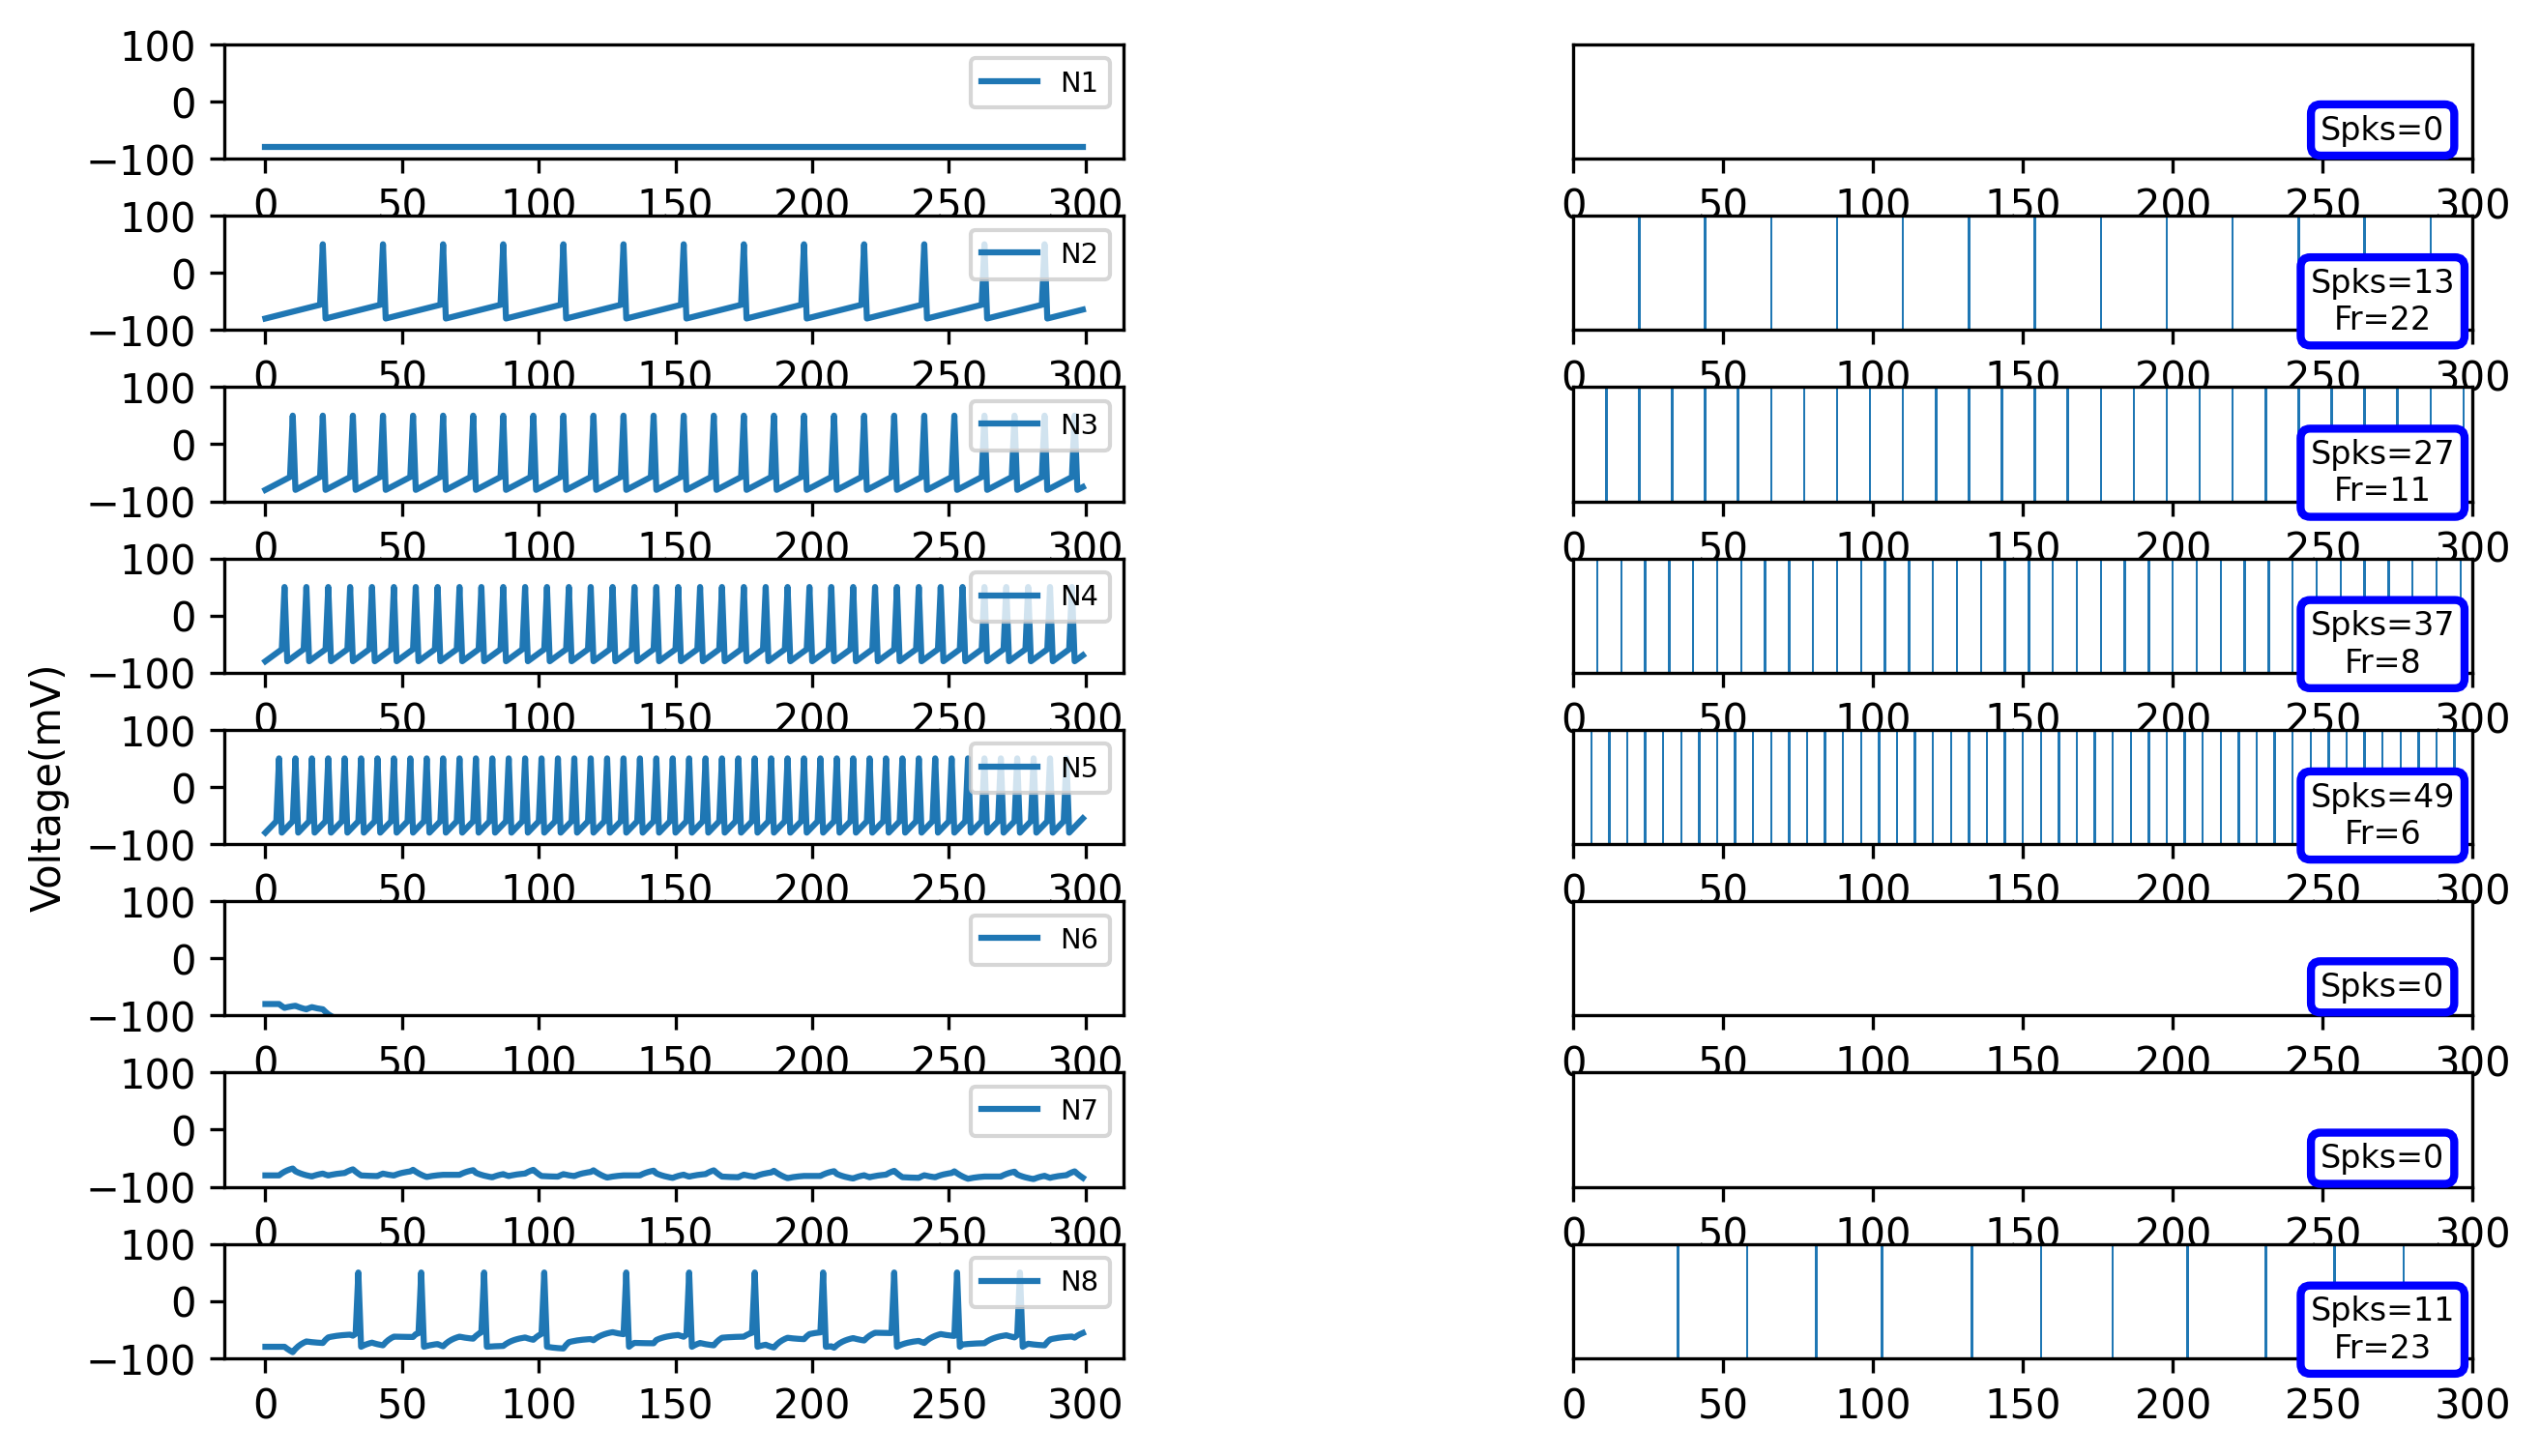

In [5]:
u = [0, 12, 25, 35, 50, 0, 0, 0]
fig, ax = plt.subplots(8, 2, figsize=(10, 6))
f = eulerMeth(1, u = u)

for i in range(len(neurons)):
    ax[i, 0].plot(f[0][i],  label=f"N{i+1}")
    ax[i, 0].legend(fontsize = 'x-small', loc='upper right')


ax[4][0].set_xlabel('t(ms)')
ax[int(len(neurons)/2)][0].set_ylabel('Voltage(mV)')
ax[0][0].legend(fontsize = 'x-small', loc='upper right')

x = range(T)

def B(ss):
    y = np.zeros(T)
    for i in ss:
        y[i] = 1
    return y

for i in range(len(neurons)):
    ax[i, 1].bar(x, B(f[2][i]),  label=f"N{i+1}")


for i in range(len(neurons)):
    lenS = (len(f[2][i]))
    toWrite = f"Spks={lenS}"
    if(lenS > 2):
        fr = f[2][i][-1] - f[2][i][-2]
        toWrite += f"\nFr={fr}"
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
    t = ax[i, 1].text(270, 0.25, toWrite, ha="center", va="center",
                size=8,
                bbox=bbox_props)
    ax[i, 0].set(ylim=(-100, 100))
    ax[i, 1].set(xlim=(0, 300), ylim=(0, 1))
    ax[i, 1].axes.yaxis.set_visible(False)

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.5)

We can see how given the input, we have got a small activity, not too signifiant as the vector didn't present any clear edge

### Part 2: Parsing a whole image

We will now simplfy the previous model and then transform an image into a set of input vectors, process the vectors through the network and obtain a output vector

We have to change some parametters, for example, changing the simulation time to $T=256$ so that we can get as maximum 255 spikes
We also need a function that prevents negative values from appearing in a matrix multiplication and some simpler matrices to avoid unnecessary calculations.

In [10]:
T      = 255

neurons = np.zeros(shape=[3, T])
for neuron in neurons:
    neuron[0] = V_reset

M_7 = np.matrix([ [6, 0, -6], 
                [-9, 9, 0], 
                [0, -9, 9], 
                [6, 0, -6], 
                [-9, 9, 0], 
                [0, -9, 9], 
                [6, 0, -6]])

M_5 = np.matrix([ [8, 0, -8], 
                [-8, 8, 0], 
                [0, -16, 16], 
                [8, 0, -8], 
                [-8, 8, 0]])

M_3 = np.matrix([ [16, 0, -16], 
                [-16, 16, 0],
                [0, -16, 16]])
M = {7: M_7, 5: M_5, 3: M_3}

We also can avoid all the $n$ first neurons as we can easily calculate the spikies that will be produced.
The main function also needs to be updated

In [11]:
def ltstSpk(iSpks, t):
    spks = iSpks.copy()
    i = bisect.bisect_left(spks, t)
    return spks[i - 1]

def gateP (t, iSpksV, opt = 0, prec = 0):
    ret = []
    for iSpks in iSpksV[:prec]:
        if(len(iSpks) > 0 and t > iSpks[0]):
            if(opt == 1):
                ret.append(gmax*GABA(t - ltstSpk(iSpks, t))*P_max)
            else:
                ret.append(gmax*AMPA(t - ltstSpk(iSpks, t))*P_max)
        else:
            ret.append(gmax*0)
    return ret

def F_func(u, m, v, num = -1, prec = 0):
    return np.dot(m[num], np.transpose(v))
    
def inSpikes(U, spikes):
    for i in range(T):
        for n, u in enumerate(U):
            if(u == 0):
                spikes[n] = []
            elif((i%int(T/u)) == (int(T/u) - 1)):
                spikes[n].append(i)
    return spikes

def eulerMeth(option, V_rest1 = V_rest, V_reset1 = V_reset, R_m1 = R_m, tau_m1 = tau_m, V_th1 = V_th, I1 = I, T1 = T, I_E = EsE, AG = 0, u = [0, 0, 0, 0, 0], prec = 0, size = 0):
    
    Ivec = []
    tau_gsra = 100
    spikes = []
    for s in range(prec + size):
        spikes.append([])
    spikes = inSpikes(np.squeeze(np.asarray(u)), spikes)
    for i in range(1,T1):
        for num, neuron in enumerate(neurons):
            dV1 = F_func(u, M[prec].getT(), [y*-((neuron[i - 1] - I_E)*R_m1) for y in gateP(i, spikes, AG, prec = prec)], num = num, prec = prec)#gateP(i, spikes, AG)*(neuron[i - 1] - I_E)*R_m1)
            neuron[i] = neuron[i-1] + dV1/tau_m1
            if neuron[i] > V_th1:
                neuron[i-1] = 50
                neuron[i] = V_reset1
                spikes[prec+num].append(i)

    
    return [10*len(spikes[-3]), 10*len(spikes[-2]), 10*len(spikes[-1])]

Finally the function that will process the image will open an image and convert it into an array of pixels, each pixel will be simplified to the brightness and we will ignore the colors.
Each row of pixels will be transformed by taking 5 pixels, processing them as the vector $u$ and the output of 3 neurons will be processed to convert it to either 3 or just 1 single pixel.

In [12]:

def procedure(matrix):
    return [[x.clip(min=0) for x in row] for row in matrix]

def modIMM(im_arr, prec = 5, size = 3, cmpct = 0):

    ofst = int((prec-size)/2)
    bar = IncrementalBar('Processing', max=len(im_arr), suffix='%(percent)d%% - %(elapsed)d(%(eta)ds remaining)')
    for i, row in enumerate(im_arr):
        ROW = ofst*[np.mean(row[0])/10] + [(np.mean(x)/10) for x in row] + ofst*[np.mean(row[-1])/10]
        for j, col in enumerate(row):
            if(j%size == (size-1) or cmpct):
                aux = ROW[(j-size+1):(j+1+2*ofst)]
                u = np.asmatrix(aux)
                v = eulerMeth(1, u = u, prec = prec, size = size)
                aux.clear()
                if(cmpct):
                    im_arr[i, j] = max(v)
                else:
                    for x, a in enumerate(v):
                        im_arr[i, (j - x)] = a
        # if(int(100*i/len(im_arr))%5 == 0):
        #     print(f"{int(100*i/len(im_arr))}%")
        bar.next()
    bar.finish()
    return im_arr

Now se just have to open an image and apply the function

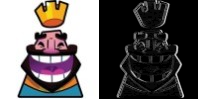

In [18]:
im = Image.open("descargaa.jpg") 
#display(im)
im_arr = np.asarray(im)
im_arrH = modIMM(im_arr, 3, 3, cmpct=1)
im_mod = Image.fromarray(im_arr)
display(Image.fromarray(np.hstack((np.asarray(im), im_mod))))




We can see how as expected the final image draw all the edges of the image, the slight disadvantage of this is that it only analizes each row, so cannot detect purely horizontal edges.
If we try to transpose the image and apply the same method we get different results:

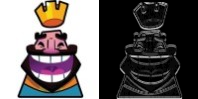

In [19]:
def transpIm(im):
    final_im = np.zeros(shape=[len(im), len(im[0]), 3], dtype="uint8")
    for i in range(len(im[0])):
        for j, row in enumerate(im):
            final_im[i, j] = row[i]
    return final_im
    
im_arr = np.asarray(im)
im_arr = modIMM(transpIm(im_arr), 3, 3, cmpct=1)
im_mod = Image.fromarray(transpIm(im_arr))
im_fin = Image.fromarray(np.hstack((np.asarray(im), im_mod)))
display(im_fin)

As we can see, this final image shows us that the horizontal edges have been captured better, so if we wanted to make a neural network that took into account both vertical and horizontal edges we could make a higher dimensional network or just make the average between the horizontal and vertical edges